<h2><center><font color='blue'>  Kriging Problem

<h3><center><font color= 'teal'> Sushant Poudel

<hr>

<h4> Problem Statement:

Perform Ordinary Kriging to predict For small area in Lamar University, TX
The file 'Trimble_Final_Data.csv' Contains the data for calculation.

<h3> Code

<h5> Import Required libraries

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_map_utils as mapu # for North Arrow
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

<h5> Set Path and Read files

In [3]:
path = 'C:/Users/Sushant/OneDrive - Lamar University/1st semester/GIS/Project/Final Project/Kriging/Kriging/Kriging'
os.chdir(path)


In [4]:
# Import files
fname = 'Trimble_Final_Data.csv'
a = pd.read_csv(fname)
a.head()

,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1


<h5> Create a Point Geodataframe from CSV file

In [5]:
# Create a geometry column from the longitude and latitude columns
jeffas = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))
jeffas.crs = 'EPSG:26915'  
jeffas.head()

,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks,geometry
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left,POINT (396103.863 3323564.158)
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right,POINT (396136.76 3323564.703)
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right,POINT (396136.411 3323541.64)
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left,POINT (396103.559 3323540.882)
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1,POINT (396123.592 3323552.059)


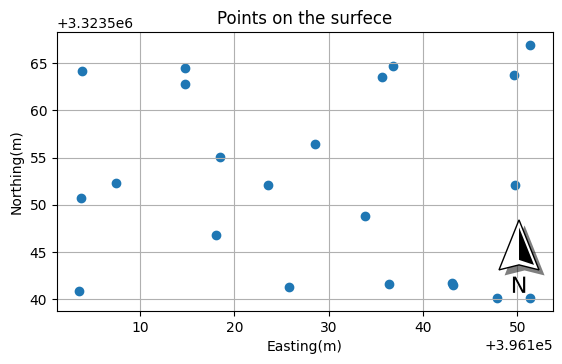

In [6]:
fig,ax = plt.subplots()
jeffas.plot(ax=ax)
plt.grid()
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.xlabel('Easting(m)')
plt.ylabel('Northing(m)')
plt.title('Points on the surfece')
plt.show()


<h5> Obtain Bounds to Create a Grid to Interpolate (extrapolate)

In [7]:
x = list(jeffas.geometry.x)
y = list(jeffas.geometry.y)
z = list(jeffas.Z)

In [8]:
# Get the bounds of Jefferson county to create a grid of size delta
delta = 1 
xmin, ymin, xmax, ymax = jeffas.total_bounds
print(xmin, ymin, xmax,ymax)
gridx = np.arange(xmin,(xmax+delta),delta)
gridy = np.arange(ymin,(ymax+delta),delta)

396103.5592 3323540.109 396151.3764 3323566.964


<h5> Perform Ordinary Kriging to Identify Best Variogram Model with Actual Data

The model that provides the best overall prediction of As as compared to measured data will be used here.  Ideally we would like to split the data into training and testing data and train the model with training data and test with the independent dataset.  Otherwise you could also use cross-validation.  However, here we simply use training error for simplicity.  

In [9]:
#Validate Input Data
x, y, z = np.array(x), np.array(y), np.array(z)
if len(x) == 0 or len(y) == 0 or len(z) == 0:
    raise ValueError("Input arrays x, y, and z cannot be empty.")
if len(x) != len(y) or len(x) != len(z):
    raise ValueError("Input arrays x, y, and z must have the same length.")
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
x, y, z = x[mask], y[mask], z[mask]

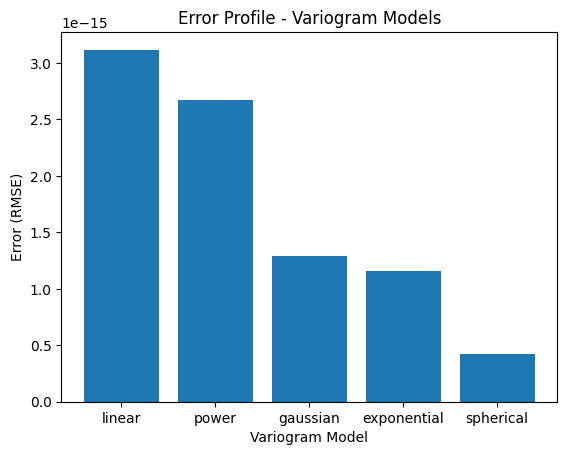

In [10]:
# Perform ordinary Kriging and evaluate variogram models
models = ['linear', 'power', 'gaussian', 'exponential', 'spherical']
varioerr = []

for m in models:
    try:
        ok = OrdinaryKriging(x, y, z, variogram_model=m, verbose=False, enable_plotting=False)
        Aspred, ss = ok.execute("points", x, y) 
        err = np.nansum((z - Aspred.ravel())**2)
        rmse = np.sqrt(err / len(z))
        varioerr.append(rmse)
    except Exception as e:
        print(f"Model {m} failed with error: {e}")
        varioerr.append(np.nan)  

models = [m for m, v in zip(models, varioerr) if not np.isnan(v)]
varioerr = [v for v in varioerr if not np.isnan(v)]

# Plot the error profile
minlim = np.min(varioerr) - np.std(varioerr)
maxlim = np.max(varioerr) + np.std(varioerr)
plt.bar(models, varioerr)
plt.ylabel('Error (RMSE)')
plt.xlabel('Variogram Model')
plt.title('Error Profile - Variogram Models')
plt.show()

The best fit model is the Spherical Model.  But you can see any of the other models also perform closely.  (Notice the values of the Y-axis).  

<h5>  Perform Ordinary Kriging with the best fit Spherical Model on a grid

In [11]:
#Perform ordinary kriging with Spherical Model (best fit model)
ok = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=False
)

z_pred, ss_pred = ok.execute('grid', gridx, gridy)
lags = ok.lags 
semivariance = ok.semivariance  
model_parameters = ok.variogram_model_parameters
sill = model_parameters[0]
range_ = model_parameters[1]
nugget = model_parameters[2]

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.0497833137880166
Full Sill: 0.12042053827424126
Range: 0.8549420916211661
Nugget: 0.07063722448622467 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



<h5> Write a function for theoretial semi-variogram and Plot the empirical and theoretical variogram clouds

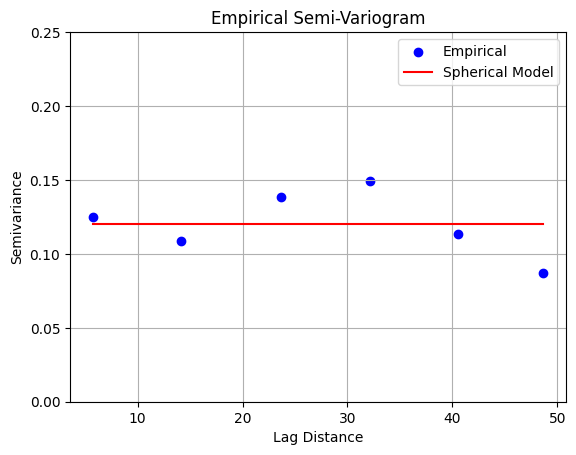

In [12]:
def spherical_variogram(h, sill, range_, nugget):
    h = np.array(h)
    gamma = np.zeros_like(h)
    mask = h <= range_  
    gamma[mask] = nugget + sill * (1.5 * (h[mask] / range_) - 0.5 * (h[mask] / range_) ** 3)
    gamma[~mask] = nugget + sill 
    return gamma

lags = ok.lags  
semivariance = ok.semivariance  
theoretical_variogram = spherical_variogram(lags, sill, range_, nugget)

#Plot
plt.figure()
plt.scatter(lags, semivariance, color='blue', label='Empirical')
plt.plot(lags, theoretical_variogram, color='red', label='Spherical Model')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Empirical Semi-Variogram')
plt.ylim(0, 0.25) 
plt.grid()
plt.legend()
plt.show()

In [13]:
# Step 1: Import the data
fname = 'Trimble_Final_Data.csv'
a = pd.read_csv(fname)
X = a['X'].values
Y = a['Y'].values
Z = a['Z'].values

#Reshape X, Y, Z into the appropriate shapes for regression
X_ = np.column_stack((X, Y))
reg = LinearRegression()
reg.fit(X_, Z)
x_range = np.linspace(X.min(), X.max(), 100) 
y_range = np.linspace(Y.min(), Y.max(), 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_pred = reg.predict(np.column_stack((X_grid.ravel(), Y_grid.ravel())))
Z_pred = Z_pred.reshape(X_grid.shape) 

from scipy.interpolate import griddata
Z_actual = griddata((X, Y), Z, (X_grid, Y_grid), method='linear')
error = Z_pred - Z_actual


## <h5> Plot the Predicted Surface on a grid

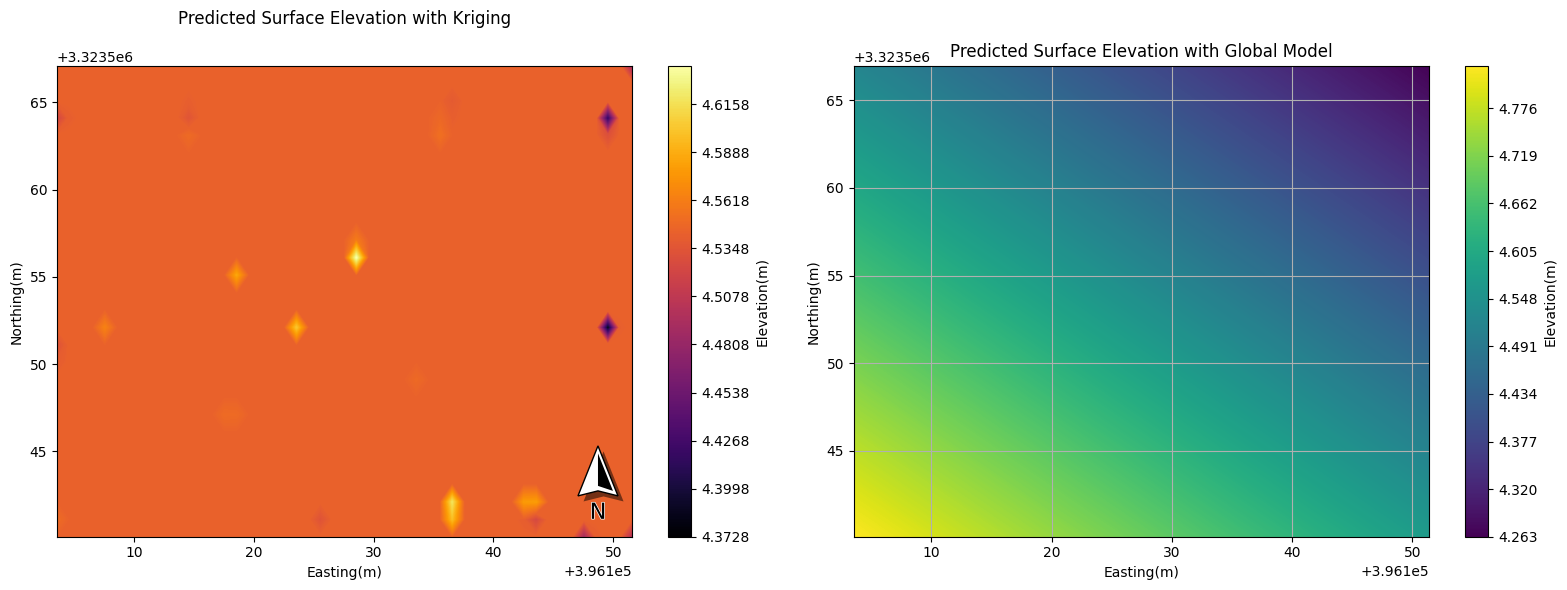

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Plot: Predicted Surface with kriging
contour1 = axes[0].contourf(gridx, gridy, z_pred, levels=500, cmap='inferno')
mapu.north_arrow.north_arrow(ax=axes[0], location="lower right", rotation={"degrees":0})
fig.colorbar(contour1, ax=axes[0], label='Elevation(m)')
axes[0].set_title('Predicted Surface Elevation with Kriging', pad=30)
axes[0].set_xlabel('Easting(m)')
axes[0].set_ylabel('Northing(m)')

# Plot: Global Model
contour2 = axes[1].contourf(X_grid, Y_grid, Z_pred, levels=500, cmap='viridis')
fig.colorbar(contour2, ax=axes[1], label='Elevation(m)')
axes[1].set_xlabel('Easting(m)')
axes[1].set_ylabel('Northing(m)')
axes[1].set_title('Predicted Surface Elevation with Global Model')
axes[1].grid(True)

#show plots
plt.tight_layout() 
plt.show()

<h5> Plot the Prediction Standard Error

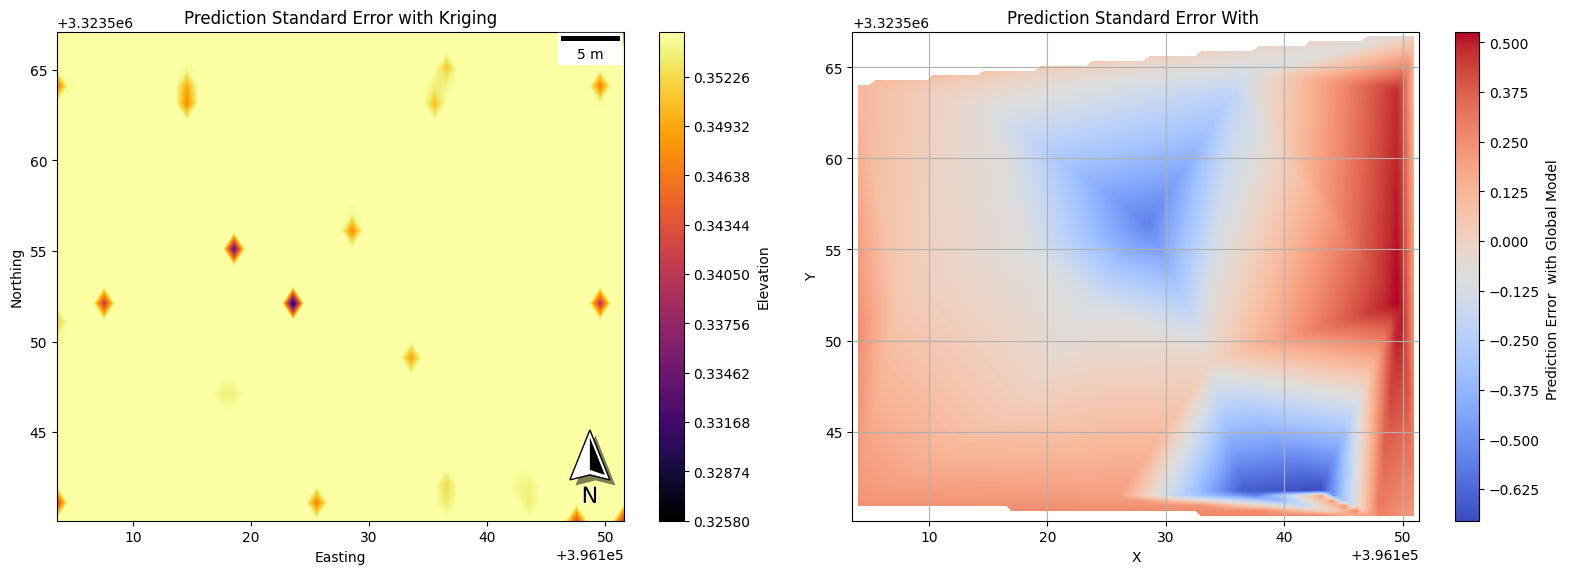

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Prediction Standard Error
contour1 = axes[0].contourf(gridx, gridy, np.sqrt(ss_pred), levels=500, cmap='inferno')
mapu.north_arrow.north_arrow(ax=axes[0], location="lower right", rotation={"degrees": 0})
scalebar = ScaleBar(0.001, "km")
axes[0].add_artist(scalebar)
fig.colorbar(contour1, ax=axes[0], label='Elevation')
axes[0].set_title('Prediction Standard Error with Kriging')
axes[0].set_xlabel('Easting')
axes[0].set_ylabel('Northing')

# Plot 2: Prediction Error
contour2 = axes[1].contourf(X_grid, Y_grid, error, levels=500, cmap='coolwarm')
fig.colorbar(contour2, ax=axes[1], label='Prediction Error  with Global Model ')
axes[1].set_title('Prediction Standard Error With ')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True)

# Show the plots
plt.tight_layout() 
plt.show()